In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import confusion_matrix
import mord
import itertools


import matplotlib.pyplot as plt
import seaborn as sns
from plot_confusion import *

In [8]:
df = pd.read_csv('data/train.csv')

In [9]:
df.columns

Index([u'Music', u'Slow songs or fast songs', u'Dance', u'Folk', u'Country',
       u'Classical music', u'Musical', u'Pop', u'Rock', u'Metal or Hardrock',
       ...
       u'Life struggles', u'Happiness in life', u'Energy levels',
       u'Small - big dogs', u'Personality', u'Finding lost valuables',
       u'Getting up', u'Interests or hobbies', u'Parents' advice',
       u'Questionnaires or polls'],
      dtype='object', length=117)

In [10]:
music = df.iloc[:,:19]
movies = df.iloc[:,19:31]
interests = df.iloc[:,31:63]
personality = df.iloc[:,63:]

In [11]:
data = {'music':music,'movies':movies,'interests':interests,'personality':personality}

In [14]:
fa_proj = {}

for k in data.keys():
    scaled = scale(data[k],with_std = False)
    fa = FactorAnalysis()
    fa.fit(scaled)
    projected = fa.fit_transform(scaled)
    
    fa_proj[k] = projected
    '''
    plt.figure(figsize=(10,4)) 
    plt.subplot(1, 2, 1)
    plt.plot(fa.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(k)
    plt.subplot(1, 2, 2)
    plt.scatter(projected[:,0],projected[:,1])
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(k)
    plt.tight_layout()
    plt.show()
    '''

## Correlations

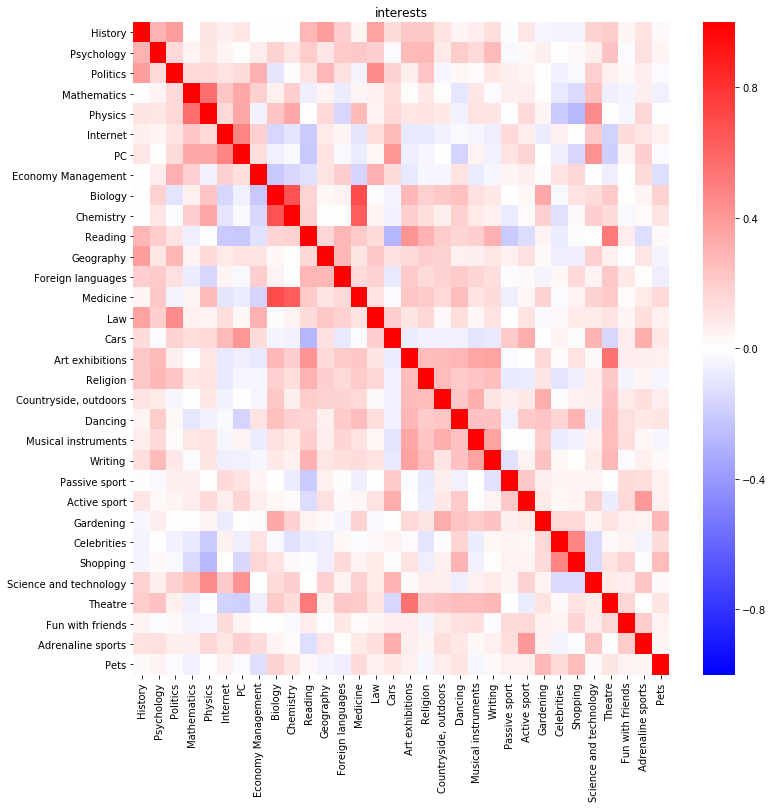

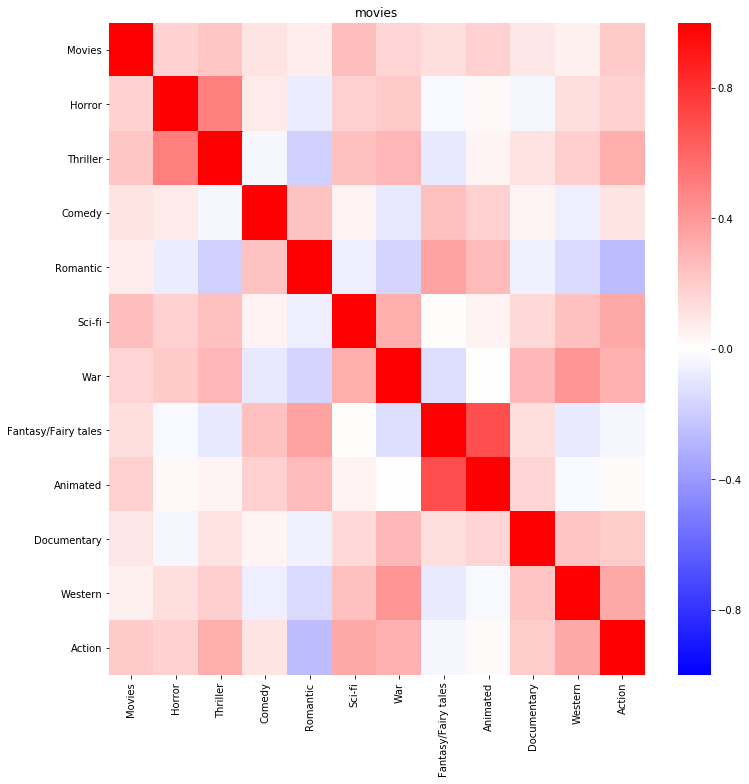

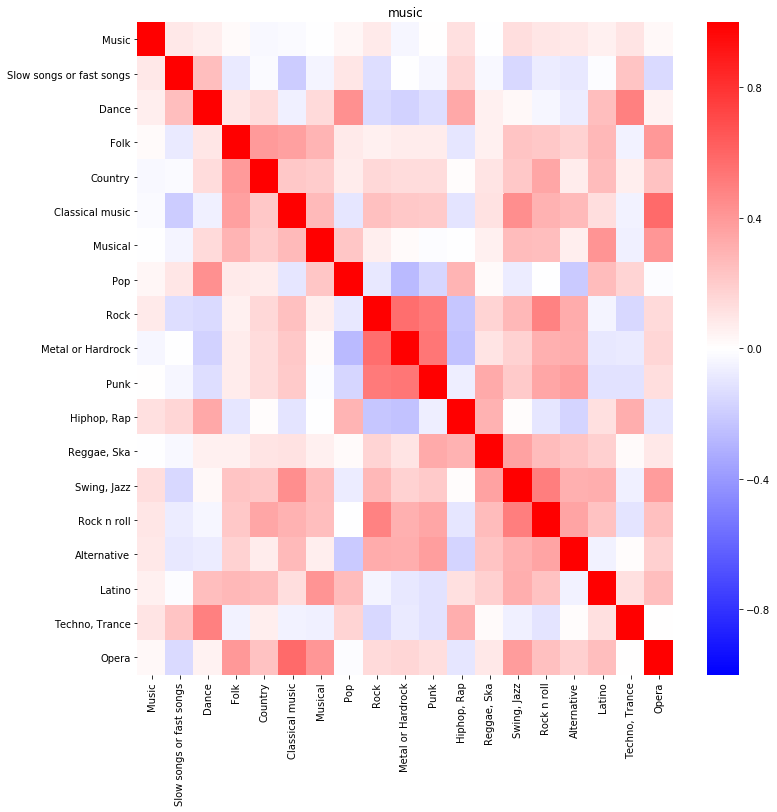

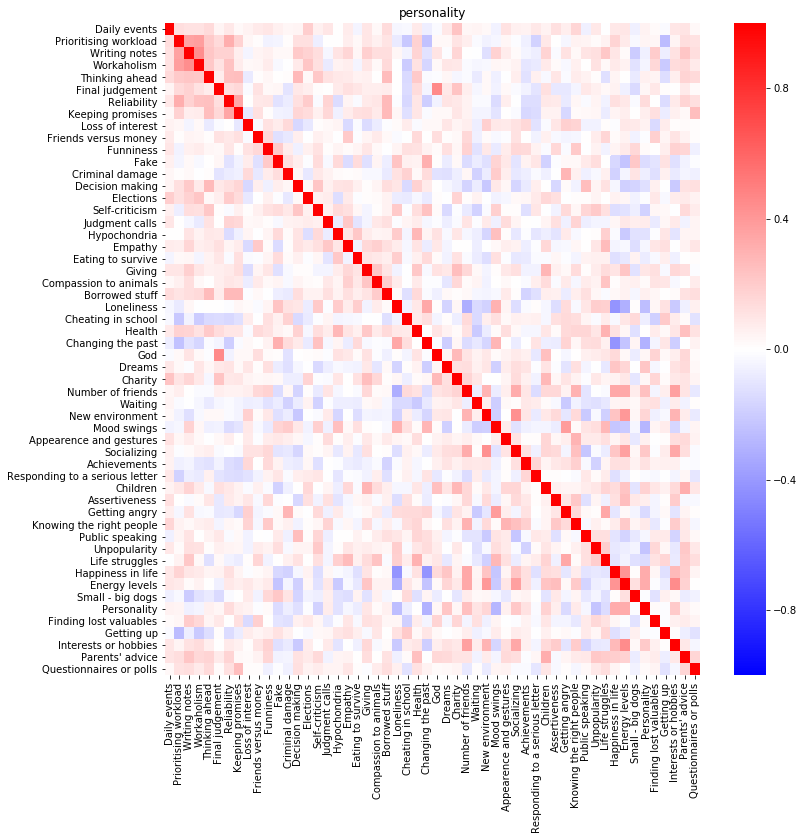

In [15]:
for k in data.keys():

    plt.figure(figsize=(12,12))
    set_ = data[k]
    sns.heatmap(set_.corr() , vmin= -1 , vmax = 1 , cmap = 'bwr', xticklabels=set_.columns , yticklabels=set_.columns)
    plt.title(k)
    plt.show()


## Unobservable Varaibles (personality)

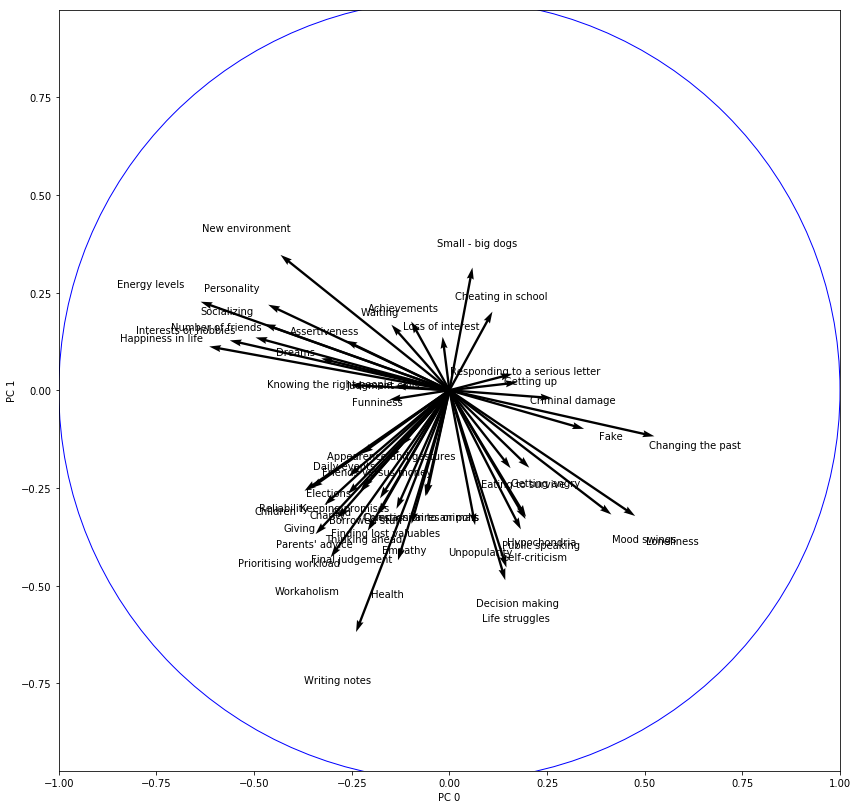

In [16]:

projected = fa_proj['personality']


PCs = fa.components_
k = 54 # max = 54 

dim1 = []
dim2 = []

for var in range(k):
    dim1.append(np.corrcoef(projected[:,0] ,  personality.iloc[:,var])[0,1])
    dim2.append(np.corrcoef(projected[:,1] ,  personality.iloc[:,var])[0,1])


# Use quiver to generate the basic plot
fig = plt.figure(figsize=(14,14))

plt.quiver(np.zeros( k ) , np.zeros( k ),
           dim1, dim2, 
           angles='xy', scale_units='xy',scale = 1 , width = .003)

# plt.quiver(np.zeros(PCs.shape[1] - ( PCs.shape[1] - k ) ), np.zeros(PCs.shape[1] - ( PCs.shape[1] - k ) ),
#            PCs[0,:k], PCs[1,:k], 
#            angles='xy', scale_units='xy',scale = 1 , width = .004, color = 'blue')

# plt.scatter(dim1,dim2 )



# Add labels based on feature names (here just numbers)

spacing = 1.2

feature_names = personality.columns[:k]
for i,j,z in zip(np.array(dim2) * spacing , np.array(dim1) * spacing , feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')

# Done
plt.show()

In [17]:
for i in range(len(dim1)):
    if dim1[i] > .35:
        print '+ ' + personality.columns[i]
    elif dim1[i] < -.25:  
        print '- ' + personality.columns[i]

- Prioritising workload
- Workaholism
- Reliability
- Elections
- Giving
+ Loneliness
+ Changing the past
- Dreams
- Charity
- Number of friends
- New environment
+ Mood swings
- Socializing
- Children
- Assertiveness
- Knowing the right people
- Happiness in life
- Energy levels
- Personality
- Interests or hobbies
- Parents' advice


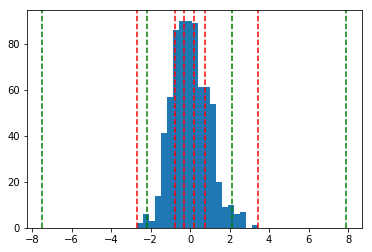

In [18]:
# Threshholding

y_fa1 , bins_1 = pd.qcut( fa_proj['personality'][:,0]  , q = 5, labels = [1,2,3,4,5] , retbins=True)

bins_2 = [-7.50522222, -2.16811586 ,   2.14454134 , 7.91857835] #used bins_1 to get this numbers

y_fa1_cut = pd.cut( fa_proj['personality'][:,0] , bins_2 , right=True, labels=[1,2,3] )


plt.hist( fa_proj['personality'][:,0] , bins = 20)

for i in list(bins_1): plt.axvline(x=i, color = 'r' , linestyle = '--' )
for i in list(bins_2): plt.axvline(x=i, color = 'green' , linestyle = '--'  )
plt.show()

 



## Ordinal Logistic Regression

In [19]:
#pip intall mord

y_true = np.array( y_fa1)  # np.array( list(map(int,personality['Writing notes'] ))) # test_y
x_fit = np.concatenate( [ fa_proj['interests'][:,:10] , fa_proj['music'][:,:5] ,fa_proj['movies'][:,:4]   ], axis=1)


###  Immediate-Threshold variant

Confusion matrix, without normalization
[[94 21  4 12 11]
 [57 20 14 20 30]
 [38 26  7 21 49]
 [28 25 11 32 45]
 [23  9  7 23 80]]


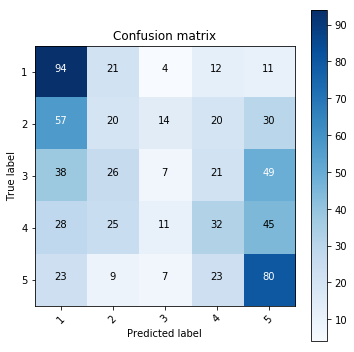

In [21]:
ord_logit = mord.LogisticIT(alpha=1.0)
ord_logit.fit(X = x_fit, y = y_true )

y_pred = ord_logit.predict(x_fit)

plot_confusion_matrix( confusion_matrix( y_true , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

### All-Threshold variant

Confusion matrix, without normalization
[[13 80 37 12  0]
 [ 5 46 59 30  1]
 [ 5 33 59 41  3]
 [ 1 25 65 43  7]
 [ 4 17 41 54 26]]


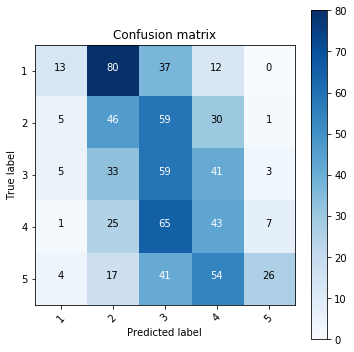

In [22]:
ord_logit = mord.LogisticAT(alpha=1.0)
ord_logit.fit(X = x_fit, y = y_true )
y_pred = ord_logit.predict(x_fit)
plot_confusion_matrix( confusion_matrix( y_true , y_pred ) , classes=[1,2,3,4,5] ,size = 5)


### Squared Error variant

Confusion matrix, without normalization
[[ 0 79 57  6  0]
 [ 0 36 83 22  0]
 [ 0 28 86 27  0]
 [ 0 16 86 39  0]
 [ 0 12 56 69  5]]


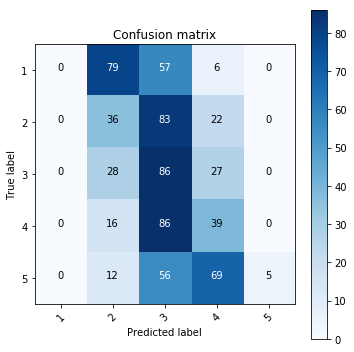

In [23]:
ord_logit = mord.LogisticSE(alpha=1.0)
ord_logit.fit(X = x_fit, y = y_true )
y_pred = ord_logit.predict(x_fit)
plot_confusion_matrix( confusion_matrix( y_true , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

### Ordinal Ridge

Confusion matrix, without normalization
[[ 3 73 59  7  0]
 [ 0 37 91 13  0]
 [ 0 28 90 23  0]
 [ 0 16 89 36  0]
 [ 0 12 59 58 13]]


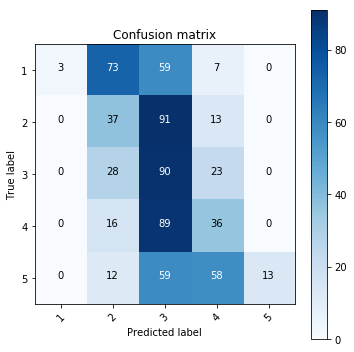

In [24]:
ord_logit = mord.OrdinalRidge(alpha=1.0)
ord_logit.fit(X = x_fit, y = y_true )
y_pred = ord_logit.predict(x_fit)
plot_confusion_matrix( confusion_matrix( y_true , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

In [25]:
scale?

Beginning to optimize
Iteration:  0
Mu:  [ 1.76405235  0.40015721  0.97873798  2.2408932 ]
Sigma:  [ 6.47247125  0.37633413  2.58593829  0.85954061]
Iteration:  500
Mu:  [-0.79553343 -1.74296326  1.10009031  0.44446444]
Sigma:  [ 0.19822677  0.13143896  0.08315484  0.29420238]
Iteration:  1000
Mu:  [-0.614433   -0.6808173   0.55535877 -0.06988163]
Sigma:  [ 0.1011387   0.11051888  0.04587832  0.07709935]
Iteration:  1500
Mu:  [-0.96207594 -1.05083031  0.30623316  1.06491372]
Sigma:  [ 0.04578764  0.09417719  0.0630919   0.10405764]
Iteration:  2000
Mu:  [-1.22831113 -0.74941993  0.36357895  0.57491856]
Sigma:  [ 0.05599482  0.11172733  0.06421828  0.11317565]
Optimization complete
Final mu:  [-0.96467262 -0.83627335  0.43183214  0.83248988]
Final sigma:  [ 0.04940165  0.09677904  0.06591744  0.11994209]
Real values:  [-0.59865394 -1.11589699  0.76666318  0.35629282]


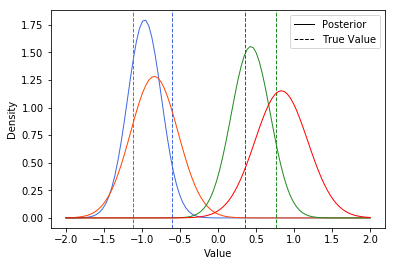

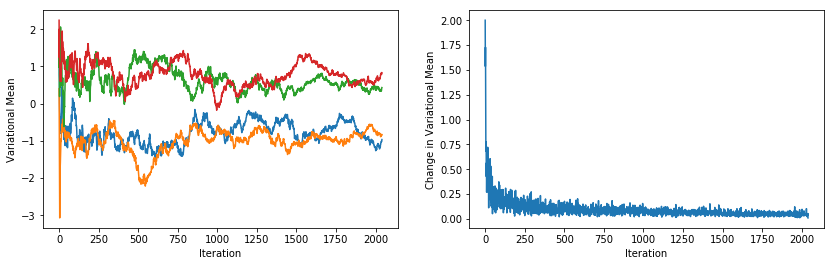

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm

N = 100
P = 4
rs = np.random.RandomState(0)
X = rs.randn(N,P)
z_real = rs.randn(P)
y = rs.binomial(1,sigmoid(np.dot(X,z_real)))

def elbo_grad(z_sample, mu, sigma):
    score_mu = (z_sample - mu)/(sigma)
    score_logsigma = (-1/(2*sigma) + np.power((z_sample - mu),2)/(2*np.power(sigma,2))) * sigma
    log_p = np.sum(y * np.log(sigmoid(np.dot(X,z_sample))) + (1-y) * np.log(1-sigmoid(np.dot(X,z_sample))))\
        + np.sum(norm.logpdf(z_sample, np.zeros(P), np.ones(P)))
    log_q = np.sum(norm.logpdf(z_sample, mu, np.sqrt(sigma)))
    return np.concatenate([score_mu,score_logsigma])*(log_p - log_q)

rs = np.random.RandomState(0)
S = 10
n_iter = 10000
mu = rs.randn(P)
G = np.zeros((2*P,2*P))
eta = 1.0
log_sigma = rs.randn(P)
mus = np.zeros((n_iter,P))
delta_lambda = np.zeros(n_iter)

print "Beginning to optimize"
for t in xrange(n_iter):
    mus[t] = mu
    if t % 500 == 0:
    	print "Iteration: ", t
        print "Mu: ", mu
        print "Sigma: ", np.exp(log_sigma)
    sigma = np.exp(log_sigma)
    samples = np.array([rs.normal(mu, np.sqrt(sigma)) for s in xrange(S)])
    grad_estimate = np.mean(np.array([elbo_grad(z_sample, mu, sigma) for z_sample in samples]),axis=0)
    G = G + np.outer(grad_estimate,grad_estimate)
    mu_new = mu + (eta * 1/np.sqrt(np.diag(G)))[:P] * grad_estimate[:P]
    log_sigma_new = log_sigma + (eta * 1/np.sqrt(np.diag(G)))[P:] * grad_estimate[P:]
    delta_lambda[t] = np.linalg.norm(mu_new-mu)
    if np.linalg.norm(mu_new-mu) < 0.01:
        break
    mu = mu_new
    log_sigma = log_sigma_new
print "Optimization complete"
print "Final mu: ", mu
print "Final sigma: ", np.exp(log_sigma)
print "Real values: ", z_real

x_plot = np.linspace(-2, 2, 100)
plt.plot(x_plot,norm.pdf(x_plot, mu[0], np.sqrt(sigma[0])),"royalblue",linewidth=1,label="Posterior")
plt.axvline(x=z_real[0],c="royalblue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x_plot,norm.pdf(x_plot, mu[1], np.sqrt(sigma[1])),c="orangered",linewidth=1)
plt.axvline(x=z_real[1],c="orangered",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[2], np.sqrt(sigma[2])),c="forestgreen",linewidth=1)
plt.axvline(x=z_real[2],c="forestgreen",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[3], np.sqrt(sigma[3])),c="red",linewidth=1)
plt.axvline(x=z_real[3],c="red",linestyle='dashed',linewidth=1)
plt.xlabel("Value")
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.show()
# plt.savefig('densities.png', format='png',bbox_inches='tight',dpi = 300)

fig = plt.figure(figsize=(14,4), facecolor='white')
ax_1 = fig.add_subplot(121, frameon=True)
ax_2 = fig.add_subplot(122, frameon=True)
ax_1.plot(range(t+1),mus[:(t+1)])
ax_1.set_xlabel("Iteration")
ax_1.set_ylabel("Variational Mean")
ax_2.plot(range(t+1),delta_lambda[:(t+1)])
ax_2.set_xlabel("Iteration")
ax_2.set_ylabel("Change in Variational Mean")
plt.show()
# plt.savefig('trace_plots.png', format='png',bbox_inches='tight',dpi=300)